In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  math
import matplotlib.cm as cm

In [2]:
df_orig = pd.read_csv("Airport_Quarterly_Passenger_Survey.csv")
########################### DATA PROCESSING ################################

df = df_orig.drop(['Quarter','Date recorded','Departure time'],axis = 1)

for column in df.columns:
    df[column].fillna(df[column].mode()[0],inplace = True)

df.to_csv("Airport_passenger_survey.csv", index = False)

df = pd.read_csv("Airport_passenger_survey.csv")
data_description = df.describe().transpose()
data_description = data_description.apply(lambda x: round(x,3))
data_description = data_description.sort_values(by=list(data_description.columns)[1:], ascending=False)
data_description.to_csv('airport_survey_description.csv')


                                               count   mean    std  min  25%  \
Ease of finding your way through the airport  3501.0  4.511  0.864  0.0  4.0   
Walking distance inside terminal              3501.0  4.404  0.908  0.0  4.0   
Cleanliness of airport terminal               3501.0  4.383  0.833  0.0  4.0   
Ambience of airport                           3501.0  4.244  0.881  0.0  4.0   
Flight information screens                    3501.0  4.235  1.335  0.0  4.0   
Feeling of safety and security                3501.0  4.202  1.197  0.0  4.0   
Thoroughness of security inspection           3501.0  4.094  1.267  0.0  4.0   
Wait time of security inspection              3501.0  4.033  1.287  0.0  3.0   
Comfort of waiting/gate areas                 3501.0  4.003  1.018  0.0  3.0   
Courtesy of security staff                    3501.0  3.971  1.421  0.0  4.0   
Availability of washrooms                     3501.0  3.919  1.427  0.0  4.0   
Cleanliness of washrooms                

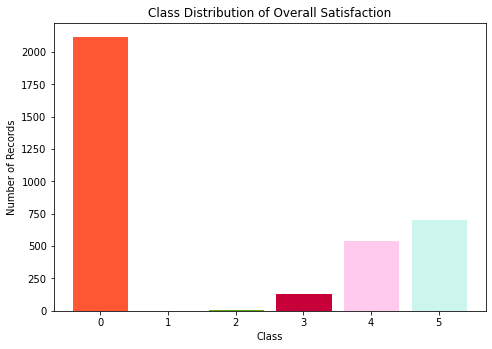

3501
3490


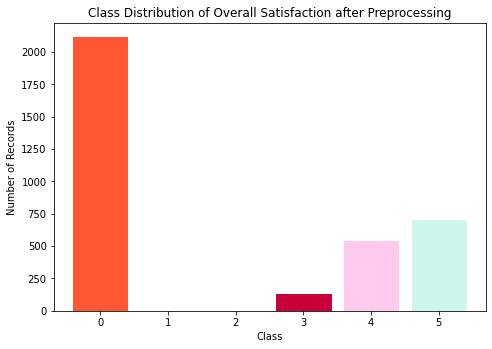

In [3]:
####### CLASS DISTRIBUTION #######
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig_all_class = plt.figure()
ax_all_class = fig_all_class.add_axes([0,0,1,1])

classes = ['0','1','2','3','4','5']
counts_all_class = [len(df[df["Overall satisfaction"]==0]),len(df[df["Overall satisfaction"]==1]),
          len(df[df["Overall satisfaction"]==2]),len(df[df["Overall satisfaction"]==3]),
          len(df[df["Overall satisfaction"]==4]),len(df[df["Overall satisfaction"]==5])
         ]


barlist = ax_all_class.bar(classes, counts_all_class)
barlist[0].set_color('#FF5733')
barlist[1].set_color('#E18068')
barlist[2].set_color('#5cab14')
barlist[3].set_color('#C70039')
barlist[4].set_color('#ffcaed')
barlist[5].set_color('#cbf5ed')
plt.title("Class Distribution of Overall Satisfaction")
plt.xlabel("Class")
plt.ylabel("Number of Records")
plt.show()


#### REMOVE OVERALL SATISFACTION = 1 and 2 ####


df.drop(df[df['Overall satisfaction']==1].index, inplace=True)
df.drop(df[df['Overall satisfaction']==2].index, inplace=True)



############# Class distribution after removing class values 1 and 2 #############
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [len(df[df["Overall satisfaction"]==0]),len(df[df["Overall satisfaction"]==1]),
          len(df[df["Overall satisfaction"]==2]),len(df[df["Overall satisfaction"]==3]),
          len(df[df["Overall satisfaction"]==4]),len(df[df["Overall satisfaction"]==5])
         ]
barlist = ax.bar(classes, counts)
barlist[0].set_color('#FF5733')
barlist[3].set_color('#C70039')
barlist[4].set_color('#ffcaed')
barlist[5].set_color('#cbf5ed')
plt.title("Class Distribution of Overall Satisfaction after Preprocessing")
plt.xlabel("Class")
plt.ylabel("Number of Records")
plt.show()



KeyError: "['Parking facilities (value for money)'] not found in axis"

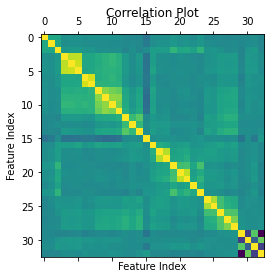

In [54]:
######  Correlation plot ######
highly_correlated = df.corr().unstack().sort_values().drop_duplicates()
plt.matshow(df.corr())
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.title("Correlation Plot")

#### Removing columns with correlation greater than 0.9 ####
df = df.drop(['Parking facilities (value for money)'], axis=1)





In [57]:
ax = df.groupby(['Overall satisfaction'])['Cleanliness of airport terminal'].agg('sum')
ax_2 = df.groupby(['Overall satisfaction'])['Cleanliness of airport terminal'].agg('count')
print(ax)
print(ax_2)

Overall satisfaction
0.0    9263.0
3.0     451.0
4.0    2224.0
5.0    3371.0
Name: Cleanliness of airport terminal, dtype: float64
Overall satisfaction
0.0    2119
3.0     130
4.0     538
5.0     703
Name: Cleanliness of airport terminal, dtype: int64


In [11]:
###### Obtaining a permanant train and test set ######

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

df = shuffle(df)

permanent_train_set, permanent_test_set = train_test_split(df, test_size=0.2)
perm_train_index = permanent_train_set.index
perm_test_index = permanent_test_set.index


In [53]:
####### RANDOM FOREST ######

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time
import statistics 
import sys
from sklearn.metrics import precision_recall_fscore_support
import pickle
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

x = permanent_train_set.iloc[:,:-1]
y = permanent_train_set["Overall satisfaction"]
x_perm_test = permanent_test_set.iloc[:,:-1]
y_perm_test = permanent_test_set["Overall satisfaction"]

accuracy_list = []
precision_list = []
recall_list =[]
fscore_list = []
support_list = []

accuracy_list_svm = []
precision_list_svm = []
recall_list_svm =[]
fscore_list_svm = []
support_svm = []

def metrics(y_test,y_predict):
    
    metrics = precision_recall_fscore_support(y_test,y_predict)
    precision = metrics[0]
    recall = metrics[1]
    fscore = metrics[2]
    support = metrics[3]
    
    precision_list.append(statistics.mean(precision))
    recall_list.append(statistics.mean(recall))
    fscore_list.append(statistics.mean(fscore))
    support_list.append(support)
    return (precision_list, recall_list, fscore_list, support)

def Random_Forest_calculate(random_state, criterion, max_depth, max_features, n_estimators, x_train, y_train, flag, x_test=0, y_test=0,class_weights =0):
    
    classifier_RF = RandomForestClassifier(random_state=random_state ,criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators=n_estimators, class_weight = class_weights)
    
    classifier_RF.fit(x_train, y_train)
    importances_features = classifier_RF.feature_importances_
   
    
    std = np.std([tree.feature_importances_ for tree in classifier_RF.estimators_],
             axis=0)
    indices = np.argsort(importances_features)[::-1]
    
    #for f in range(x_train.shape[1]):
        #print("%d. feature %d (%f)" % (f + 1, indices[f], importances_features[indices[f]]))

    
    if(flag==1):
        filename = 'random_forest_model.sav'
        pickle.dump(classifier_RF,open(filename,'wb'))
    else:
        y_predict = classifier_RF.predict(x_test)
        accuracy = accuracy_score(y_test,y_predict)
        accuracy_list.append(accuracy)

        precision_list, recall_list, fscore_list, support_rf = metrics(y_test,y_predict)
        return accuracy_list, precision_list, recall_list, fscore_list, support_rf

def SVM_classifier(C, gamma, x_train, y_train, flag, x_test=0, y_test=0, class_weights =0):
    clf_svm = svm.SVC(kernel='rbf', C=C, gamma=gamma, class_weight = class_weights)
    clf_svm.fit(x_train, y_train)
    
    if(flag==1):
        filename = 'svm_model.sav'
        pickle.dump(clf_svm,open(filename,'wb'))
    else:
        y_predict = clf_svm.predict(x_test)
        accuracy = accuracy_score(y_test, y_predict)
        accuracy_list_svm.append(accuracy)
        precision_list_svm, recall_list_svm, fscore_list_svm, support_svm = metrics(y_test,y_predict)
        return accuracy_list_svm, precision_list_svm, recall_list_svm, fscore_list_svm, support_svm

'''
 ###### Finding Best Parameters for Random Forest #####

param_grid = { 
'n_estimators': [200,900],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,6,7,8,9,10],
'criterion' :['gini', 'entropy']
}
classifier_RF = RandomForestClassifier(random_state=0)  
crossval_RF = GridSearchCV(estimator=classifier_RF, param_grid=param_grid, cv= 5)
crossval_RF.fit(x, y)
print("BEST PARAMETERS FOR Random Forest",crossval_RF.best_params_)

  
    ###### Finding Best Parameters for SVM #####
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]} 
    
classifier_SVM = GridSearchCV(svm.SVC(), param_grid, verbose=1)
classifier_SVM.fit(x, y)
print("Best Parameters for SVM ", classifier_SVM.best_params_)
    

'''
accuracy_list_RF = []
precision_list_RF = []
recall_list_RF =[]
fscore_list_RF = []
support_RF = []

accuracy_list_SVM = []
precision_list_SVM = []
recall_list_SVM =[]
fscore_list_SVM = []
support_SVM = []

class_weights = class_weight.compute_class_weight('balanced', np.unique(y),y) 
class_weights = {0:class_weights[0], 3:class_weights[1], 4:class_weights[2], 5:class_weights[3]}

'''
k_fold = KFold(n_splits=4, random_state=None)
count = 0
for train_idx, test_idx in k_fold.split(x):
    #print("TRAIN:", train_idx, "TEST:", test_idx)
    predicted_list_y_value = []
    x_train = x.iloc[train_idx]
    x_test  = x.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]
    
  
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y),y) 
    class_weights = {0:class_weights[0], 3:class_weights[1], 4:class_weights[2], 5:class_weights[3]}
    #print(class_weights)
    accuracy_list_SVM, precision_list_SVM, recall_list_SVM, fscore_list_SVM, support_svm = SVM_classifier(C = 10, gamma =  0.001, x_train=x_train, y_train=y_train, flag = 0, x_test = x_test, y_test=y_test, class_weights = class_weights)
    accuracy_list_RF, precision_list_RF, recall_list_RF, fscore_list_RF, support_RF = Random_Forest_calculate(0, 'gini', 9, 'auto', 500, x_train=x_train, y_train=y_train, flag = 0, x_test=x_test, y_test=y_test, class_weights = class_weights)
    
    print("*"*100)
    
    average_accuracy_RF = statistics.mean(accuracy_list_RF)
    average_precision_RF = statistics.mean(precision_list_RF)
    average_recall_RF = statistics.mean(recall_list_RF)
    average_f1_RF = statistics.mean(fscore_list_RF)
    
    average_accuracy_SVM = statistics.mean(accuracy_list_SVM)
    average_precision_SVM = statistics.mean(precision_list_SVM)
    average_recall_SVM = statistics.mean(recall_list_SVM)
    average_f1_SVM = statistics.mean(fscore_list_SVM)
    
    count = count+1
    if count == 4:
        print("Avearge Accuracy RF = ", average_accuracy_RF)
        print("Average Precision RF = ", average_precision_RF)
        print("Average Recall RF = ",average_recall_RF)   
        print("Average F1 Score RF = ", average_f1_RF)
        print("Support RF = ", support_RF)
        
        print("Avearge Accuracy SVM = ", average_accuracy_SVM)
        print("Average Precision SVM = ", average_precision_SVM)
        print("Average Recall SVM = ", average_recall_SVM)   
        print("Average F1 Score SVM = ", average_f1_SVM)
        print("Support SVM = ", support_svm)
'''

rf_model = Random_Forest_calculate(random_state=0, criterion='gini', max_depth=9, max_features='auto', n_estimators=500, x_train=x, y_train=y, flag=1,x_test=0, y_test=0, class_weights = class_weights)
rf_loaded_model = pickle.load(open('random_forest_model.sav', 'rb'))
rf_y_predicted_values = rf_loaded_model.predict(x_perm_test)
accuracy_score_rf = accuracy_score(y_perm_test, rf_y_predicted_values)
print("The accuracy of Random Forest is ",accuracy_score_rf*100)
print('Classification Report')
print(classification_report(y_perm_test, rf_y_predicted_values))


svm_model = SVM_classifier(C = 10, gamma =  0.001,x_train=x, y_train=y, flag = 1, x_test = 0, y_test=0, class_weights = class_weights)
svm_loaded_model = pickle.load(open('svm_model.sav','rb'))
svm_y_predicted_values = svm_loaded_model.predict(x_perm_test)
accuracy_score_svm = accuracy_score(y_perm_test, svm_y_predicted_values)
print("The Accuracy of SVM",accuracy_score_svm*100)    
print(classification_report(y_perm_test, svm_y_predicted_values))


SVC(C=10, cache_size=200,
    class_weight={0: 0.4110718492343934, 3: 7.05050505050505,
                  4: 1.582766439909297, 5: 1.259927797833935},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Ranking of features:
****************************************************************************************************
SVC(C=10, cache_size=200,
    class_weight={0: 0.4110718492343934, 3: 7.05050505050505,
                  4: 1.582766439909297, 5: 1.259927797833935},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Ranking of features:
****************************************************************************************************
SVC(C=10, cache_size=200,
    class_weight={0: 0.4110718492343934, 3: 7.05050505050505

'\n\nrf_model = Random_Forest_calculate(random_state=0, criterion=\'gini\', max_depth=9, max_features=\'auto\', n_estimators=500, x_train=x, y_train=y, flag=1,x_test=0, y_test=0, class_weights = class_weights)\n\nrf_loaded_model = pickle.load(open(\'random_forest_model.sav\', \'rb\'))\nrf_y_predicted_values = rf_loaded_model.predict(x_perm_test)\naccuracy_score_rf = accuracy_score(y_perm_test, rf_y_predicted_values)\nprint("The accuracy of Random Forest is ",accuracy_score_rf*100)\n\nprint(\'Classification Report\')\nprint(classification_report(y_perm_test, rf_y_predicted_values))\n\n\nsvm_model = SVM_classifier(C = 10, gamma =  0.001,x_train=x, y_train=y, flag = 1, x_test = 0, y_test=0, class_weights = class_weights)\nsvm_loaded_model = pickle.load(open(\'svm_model.sav\',\'rb\'))\nsvm_y_predicted_values = svm_loaded_model.predict(x_perm_test)\naccuracy_score_svm = accuracy_score(y_perm_test, svm_y_predicted_values)\nprint("The Accuracy of SVM",accuracy_score_svm*100)    \nprint(classi

AxesSubplot(0.125,0.125;0.775x0.755)


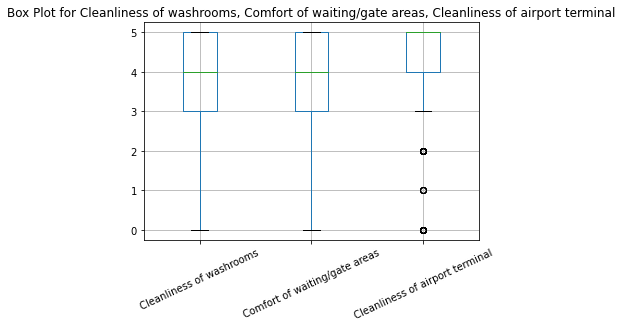

In [58]:
boxplot_features = df_orig.boxplot(column=['Cleanliness of washrooms','Comfort of waiting/gate areas','Cleanliness of airport terminal'],rot=25)
boxplot_features.set_title('Box Plot for Cleanliness of washrooms, Comfort of waiting/gate areas, Cleanliness of airport terminal')
print(boxplot_features)